# RecSys Challenge - Feature Engineering and Analysis

*Alvin Karanja*

In this notebook, I perform the feature engineering and analysis of training features for the RecSys Challenge data set. The analysis includes visualising the distribution of engineered features relative to the target variable, and observing trends in the data. The features are then used to train prediction models in a separate notebook.

Note the descriptions and rationale for the features selected is discussed in the main report, this notebook is focused purely on implementation and analysis.

To reproduce the results in this notebook, please ensure you run the `eda.ipynb` notebook first to generate the required data files.

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi as PI
from sklearn.preprocessing import StandardScaler

# Source Data
BUYS_DATA = './data/yoochoose-buys.csv'
CLICKS_DATA = './data/yoochoose-clicks.csv'

# Temporary Data
_SESSION_DATA = './tmp/session_data.csv'
_ITEM_DATA = './tmp/item_data.csv'

# Development Data
TEST_SESSION = './data/test_session.csv'
VAL_SESSION = './data/val_session.csv'
TRAIN_VAL_SESSION = './data/train_val_session.csv'
TRAIN_SESSION = './data/train_session.csv'

TEST_ITEM = './data/test_item.csv'
VAL_ITEM = './data/val_item.csv'
TRAIN_VAL_ITEM = './data/train_val_item.csv'
TRAIN_ITEM = './data/train_item.csv'

# Constants
session_scaler = StandardScaler()
item_scaler = StandardScaler()
FIG_SIZE = (8, 6)
RANDOM_STATE = 42

# Assure directories exist
os.makedirs('./tmp', exist_ok=True) # Temporary data directory

## 1. Preprocessing

In this section we will focus on preprocessing the data, producing the features necessary for both the development of the session purchase classifier and the item purchase classifier.

### 1.1 Session Classifier Features

We start by doing basic feature engineering for the session purchase classifier. This classifier will be used to predict whether a session will result in a purchase or not. We calculate aggregate statistics within the following code chunk, namely:

- `session_clicks`: The number of clicks in the session.
- `session_length`: The total time spent in the session.
- `day_of_week`: Binary flag for if the session occurred on a weekend or not.
- `hour_sin`: The sine transformation of the hour of the day to capture cyclical patterns.
- `hour_cos`: The cosine transformation of the hour of the day to capture cyclical patterns.
- `unique_items`: The number of unique items clicked in the session.
- `unique_categories`: The number of unique categories clicked in the session.

We calculate propensity based features later in section 1.5 after splitting the data into training and test sets. 

In [ ]:
# Load clicks data with correct types, for 
# session classifier
session_df = pd.read_csv(
    CLICKS_DATA,
    dtype={
        'session_id': 'str',
        'item_id': 'str',
        'category': 'str'
    },
)
session_df['time'] = pd.to_datetime(
    session_df['time'], 
    utc=True, 
    format='mixed'
)

# Group by session ID and aggregate data
session_df = session_df.groupby('session_id').agg(
    session_clicks=('session_id', 'count'),
    time=('time', 'min'), # first click time
    session_length=('time', lambda x: (x.max() - x.min()).total_seconds() / 60 ), # mins
    day_of_week=('time', lambda x: 1 if x.min().weekday() >= 5 else 0), # 1 for weekend, 0 for weekday
    hour_sin=('time', lambda x: np.sin((x.min().hour * 2 * PI) / 24)), # sin transformation of hour
    hour_cos=('time', lambda x: np.cos((x.min().hour * 2 * PI) / 24)), # cos transformation of hour
    unique_items=('item_id', 'nunique'), # number of unique items in session
    unique_categories=('category', 'nunique'), # number of unique categories in session
).reset_index()

# Log scale features with long tails
session_df['session_clicks'] = np.log1p(session_df['session_clicks'])
session_df['session_length'] = np.log1p(session_df['session_length'])
session_df['unique_items'] = np.log1p(session_df['unique_items'])
session_df['unique_categories'] = np.log1p(session_df['unique_categories'])

# Normalize clicks and length
session_features_to_norm = [
    'session_clicks', 
    'session_length', 
    'unique_items', 
    'unique_categories'
]
session_features_normalised = [f'{f}_z' for f in session_features_to_norm]

session_df[session_features_normalised] = session_scaler.fit_transform(
    session_df[session_features_to_norm]
)

# Save session data to temporary file
# and clear to free memory
session_df.to_csv(_SESSION_DATA, index=False)
del session_df

### 1.2 Item Classifier Features

Next, we do the basic feature engineering for the item purchase classifier. This classifier will be used to predict whether an item will be purchased or not. We calculate aggregate statistics within the following code chunk, namely:

- `item_time`: The time spent on the item.
- `item_clicks`: The number of clicks on the item.
- `item_categories`: The number of unique categories clicked on the item.
- `day_of_week`: Binary flag for if the item was clicked on a weekend or not.
- `hour_sin`: The sine transformation of the hour of the day to capture cyclical patterns.
- `hour_cos`: The cosine transformation of the hour of the day to capture cyclical patterns.

Propensity based features are also calculated later in section 1.5 after splitting the data into training and test sets.

In [ ]:
# Load clicks data with correct types, for 
# item classifier
clicks_df = pd.read_csv(
    CLICKS_DATA,
    dtype={
        'session_id': 'str',
        'item_id': 'str',
        'category': 'str'
    },
)
clicks_df['time'] = pd.to_datetime(clicks_df['time'], utc=True, format='mixed')

# Calculate time spent on each item in a session.
# This is done by summing the time spent on each item
# in a session.

# Sort by session and time
clicks_df = clicks_df.sort_values(by=['session_id', 'time'])

# Shift time within session to get delta
clicks_df['next_time'] = clicks_df.groupby('session_id')['time'].shift(-1)
clicks_df['time_diff'] = (clicks_df['next_time'] - clicks_df['time']).dt.total_seconds() / 60  # mins

# Fill missing last click durations with 0
clicks_df['time_diff'] = clicks_df['time_diff'].fillna(0)

# Aggregate time spent on each item in a session
item_time_df = clicks_df.groupby(['session_id', 'item_id'])['time_diff'].sum().reset_index()
item_time_df.rename(columns={'time_diff': 'item_time'}, inplace=True)

# Group by session ID and item ID and aggregate data
feature_df = clicks_df.groupby(['session_id', 'item_id']).agg(
    item_clicks=('item_id', 'count'),
    time=('time', 'min'),  # first click time
    day_of_week=('time', lambda x: 1 if x.min().weekday() >= 5 else 0), # 1 for weekend, 0 for weekday
    hour_sin=('time', lambda x: np.sin((x.min().hour * 2 * PI) / 24)), # sin transformation of hour
    hour_cos=('time', lambda x: np.cos((x.min().hour * 2 * PI) / 24)), # cos transformation of hour
    item_categories=('category', 'nunique'), # number of unique categories in session for item
).reset_index()

# Merge the item time data with the feature data
item_df = feature_df.merge(item_time_df, on=['session_id', 'item_id'], how='left')

# Log scale features with long tails
item_df['item_clicks'] = np.log1p(item_df['item_clicks'])
item_df['item_time'] = np.log1p(item_df['item_time'])
item_df['item_categories'] = np.log1p(item_df['item_categories'])

# Normalise item clicks and time spent
item_features_to_norm = ['item_clicks', 'item_time', 'item_categories']
item_features_normalised = [f'{f}_z' for f in item_features_to_norm]

item_df[item_features_normalised] = item_scaler.fit_transform(
    item_df[item_features_to_norm]
)

# Save item data to temporary file
# and clear to free memory
item_df.to_csv(_ITEM_DATA, index=False)
del item_df, clicks_df, item_time_df, feature_df

### 1.3 Data Labelling

Next we label the data for the session and item classifiers. The session classifier is labelled based on whether the session resulted in a purchase or not, while the item classifier is labelled based on whether the item was purchased or not.

We use sets to store the session IDs and item IDs that resulted in a purchase, and then use these sets to label the data.

In [ ]:
# We load the data of buys into sets to
# identify if a purchase was made
buys_df = pd.read_csv(
    BUYS_DATA,
    dtype={
        'session_id': 'str',
        'item_id': 'str',
        'price': 'float64',
        'quantity': 'int64'
    },
)

buys_df['time'] = pd.to_datetime(buys_df['time'], utc=True, format='mixed')
session_buys_set = set(buys_df['session_id'])
item_buys_set = set(zip(buys_df['session_id'], buys_df['item_id']))

del buys_df

In [ ]:
# Label the session data with buys
session_df = pd.read_csv(
    _SESSION_DATA,
    dtype={
        'session_id': 'str',
    },
)

session_df['session_purchase'] = session_df['session_id'].isin(session_buys_set).astype(int)

# Save data and clear memory
session_df.to_csv(_SESSION_DATA, index=False)
del session_df

# Label the item data with buys
item_df = pd.read_csv(
    _ITEM_DATA,
    dtype={
        'session_id': 'str',
        'item_id': 'str',
    },
)

item_df['session_purchase'] = item_df['session_id'].isin(session_buys_set).astype(int)
item_df['item_purchase'] = item_df.apply(
    lambda row: 1 if (row['session_id'], row['item_id']) in item_buys_set else 0,
    axis=1
)

# Save data and clear memory
item_df.to_csv(_ITEM_DATA, index=False)
del item_df

### 1.4 Data Splitting

We then continue to split the data into training, validation and test sets. The training set is used to train the models, the validation set is used to tune the hyperparameters of the models, and the test set is used to evaluate the performance of the models.

Note we split the data by session ID to ensure that the same session is not present in both the training and test sets. This is important to avoid data leakage and ensure that the models are evaluated on unseen data.

In [ ]:
# We split the data into training, validation
# and test sets for both session and item
# classifiers based on session IDs.
session_df = pd.read_csv(_SESSION_DATA)
item_df = pd.read_csv(_ITEM_DATA)

# Train + Validation - Test Split
train_val_sessions = session_df['session_id'] \
    .drop_duplicates() \
    .sample(frac=(2/3), random_state=RANDOM_STATE) \
    .tolist()

train_val_session_df = session_df[session_df['session_id'].isin(train_val_sessions)]
test_session_df = session_df[~session_df['session_id'].isin(train_val_sessions)]

train_val_item_df = item_df[item_df['session_id'].isin(train_val_sessions)]
test_item_df = item_df[~item_df['session_id'].isin(train_val_sessions)]

# Train - Validation Split
train_sessions = train_val_session_df['session_id'] \
    .drop_duplicates() \
    .sample(frac=(0.8), random_state=RANDOM_STATE) \
    .tolist()

train_session_df = train_val_session_df[train_val_session_df['session_id'].isin(train_sessions)]
val_session_df = train_val_session_df[~train_val_session_df['session_id'].isin(train_sessions)]

train_item_df = train_val_item_df[train_val_item_df['session_id'].isin(train_sessions)]
val_item_df = train_val_item_df[~train_val_item_df['session_id'].isin(train_sessions)]

### 1.5 Propensity Score Calculation

Finally, we calculate the propensity scores for both the session and item classifiers. To avoid data leakage, we calculate the propensity scores on the respective training sets only, that is on the training set for the validation set, and the training + validation set for the test set. This ensures that the propensity scores are not influenced by the test set, and that the models are evaluated on unseen data.

We then incorporate propensity features into the data, specifically:

**Session Classifier**:

- `max_item_propensity`: The maximum propensity score of any item in the session.
- `avg_item_propensity`: The mean propensity score of all items in the session.

**Item Classifier**:

- `item_propensity`: The propensity score of the item.

Note that whilst calculating the propensity scores, there is a chance that an item is not present in the training set, in which case we assign a propensity score equivalent to the mean propensity score of the training set. This ensures that we do not have missing values in the propensity scores. This is used as a naive approach to handle unseen items in the training set, and is a common practice in recommendation systems.


In [ ]:
# Calculate propensity scores
propensity_val = train_item_df.groupby('item_id').agg(
    item_propensity=('item_purchase', 'mean')
).reset_index()

propensity_test = train_val_item_df.groupby('item_id').agg(
    item_propensity=('item_purchase', 'mean')#
).reset_index()

# Merge propensity scores with item data
train_item_df = train_item_df.merge(propensity_val, on='item_id', how='left')
val_item_df = val_item_df.merge(propensity_val, on='item_id', how='left')

train_val_item_df = train_val_item_df.merge(propensity_test, on='item_id', how='left')
test_item_df = test_item_df.merge(propensity_test, on='item_id', how='left')

# For unseen items in validation set, fill with mean propensity
mean_propensity_val = propensity_val['item_propensity'].mean()
val_item_df['item_propensity'] = val_item_df['item_propensity'].fillna(mean_propensity_val)
train_item_df['item_propensity'] = train_item_df['item_propensity'].fillna(mean_propensity_val)

mean_propensity_test = propensity_test['item_propensity'].mean()
train_val_item_df['item_propensity'] = train_val_item_df['item_propensity'].fillna(mean_propensity_test)
test_item_df['item_propensity'] = test_item_df['item_propensity'].fillna(mean_propensity_test)

# Aggregate propensity scores for session data
train_agg = train_item_df.groupby('session_id').agg(
    avg_item_propensity=('item_propensity', 'mean'),
    max_item_propensity=('item_propensity', 'max'),
).reset_index()

val_agg = val_item_df.groupby('session_id').agg(
    avg_item_propensity=('item_propensity', 'mean'),
    max_item_propensity=('item_propensity', 'max'),
).reset_index()

train_val_agg = train_val_item_df.groupby('session_id').agg(
    avg_item_propensity=('item_propensity', 'mean'),
    max_item_propensity=('item_propensity', 'max'),
).reset_index()

test_agg = test_item_df.groupby('session_id').agg(
    avg_item_propensity=('item_propensity', 'mean'),
    max_item_propensity=('item_propensity', 'max'),
).reset_index()

# Merge propensity scores with session data
train_session_df = train_session_df.merge(train_agg, on='session_id', how='inner')
val_session_df = val_session_df.merge(val_agg, on='session_id', how='inner')
train_val_session_df = train_val_session_df.merge(train_val_agg, on='session_id', how='inner')
test_session_df = test_session_df.merge(test_agg, on='session_id', how='inner')

# Save results and clear memory
train_session_df.to_csv(TRAIN_SESSION, index=False)
val_session_df.to_csv(VAL_SESSION, index=False)
train_val_session_df.to_csv(TRAIN_VAL_SESSION, index=False)
test_session_df.to_csv(TEST_SESSION, index=False)

train_item_df.to_csv(TRAIN_ITEM, index=False)
train_val_item_df.to_csv(TRAIN_VAL_ITEM, index=False)
val_item_df.to_csv(VAL_ITEM, index=False)
test_item_df.to_csv(TEST_ITEM, index=False)

# Clear memory
del train_session_df, val_session_df, train_val_session_df, test_session_df
del train_item_df, train_val_item_df, val_item_df, test_item_df

## 2. Training Data EDA

Before proceeding to train the models, we perform some exploratory data analysis (EDA) on the training data. This includes visualising the distribution of engineered features relative to the target variable, and observing trends in the data.

Note that we only perform this EDA on the training data, as the validation and test sets are used for model evaluation and hyperparameter tuning, and we do not want to bias the results by looking at the validation or test sets.

### 2.1 Target Variable Distribution

We start by looking at the distribution of the target variable for both classifiers. This will help us understand the balance of the classes and whether we need to apply any techniques to handle class imbalance.

In [4]:
# Target variable for session classifier
train_session_df = pd.read_csv(TRAIN_SESSION)
positive_sessions = train_session_df['session_purchase'].sum() / len(train_session_df)

# Target variable for item classifier
train_item_df = pd.read_csv(TRAIN_ITEM)
positive_items = train_item_df['item_purchase'].sum() / len(train_item_df)

print(f"Positive samples for purchase classifier: {positive_sessions:.2%}")
print(f"Positive samples for item classifier: {positive_items:.2%}")

Positive samples for purchase classifier: 5.51%
Positive samples for item classifier: 3.95%


We observe that both classifiers have a significant class imbalance, with the majority of sessions and items not resulting in a purchase. This is a common scenario in recommendation systems, and we will need to incorporate upsampling to handle this class imbalance during model training.

### 2.2 Item Propensity Distribution

We then observe how the propensity scores are distributed for both classifiers. This will help us understand how informative the propensity scores are, and whether they can be used to improve the performance of the models.

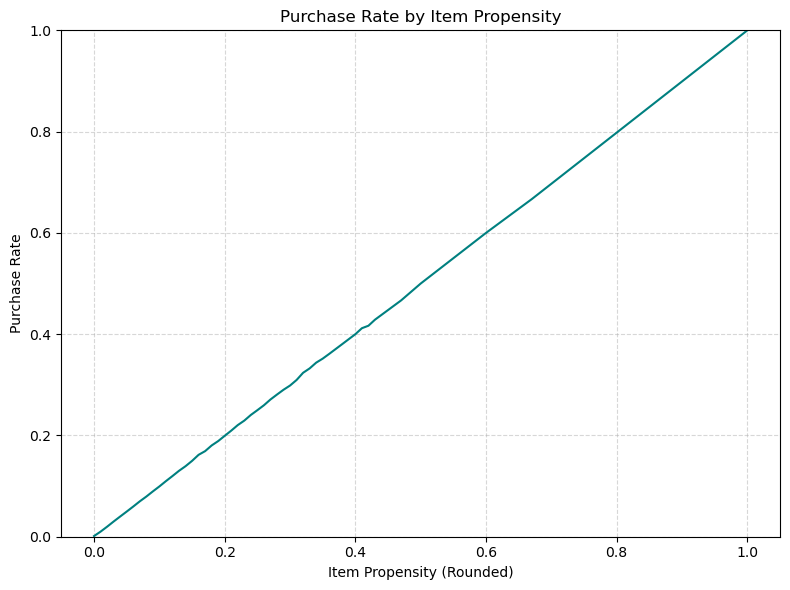

In [3]:
# Aggregate item propensity scores against
# purchase rate to visualise the relationship
train_item_df['item_propensity_rnd'] = train_item_df['item_propensity'].round(2)

item_propensity_agg = train_item_df.groupby('item_propensity_rnd').agg(
    purchase_rate=('item_purchase', 'mean')
).reset_index()

plt.figure(figsize=FIG_SIZE)
sns.lineplot(data=item_propensity_agg, x='item_propensity_rnd', y='purchase_rate', color='teal')

plt.title('Purchase Rate by Item Propensity')
plt.xlabel('Item Propensity (Rounded)')
plt.ylabel('Purchase Rate')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

As expected, as the propensity score increases, the likelihood of an item being purchased also increases. This is a good indication that the propensity scores are informative and can be used to improve the performance of the models.

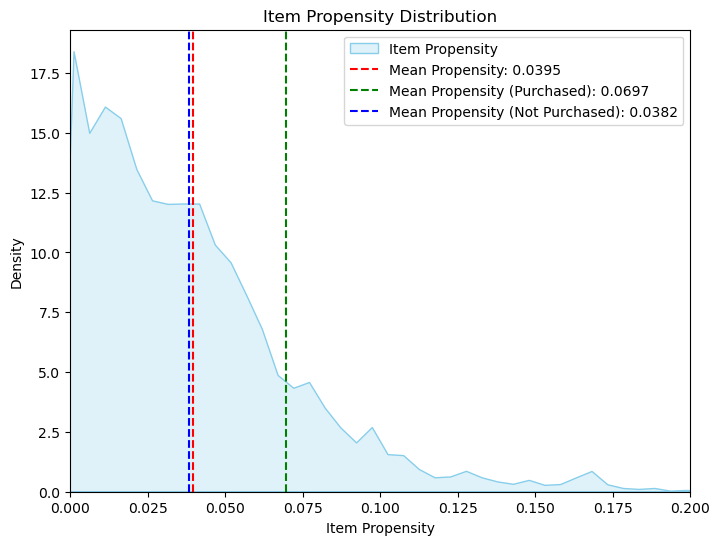

In [4]:
# Visualise the distribution of item propensity scores
item_propensity_mean = train_item_df['item_propensity'].mean()
item_propensity_mean_purchased = train_item_df[train_item_df['item_purchase'] == 1]['item_propensity'].mean()
item_propensity_mean_not_purchased = train_item_df[train_item_df['item_purchase'] == 0]['item_propensity'].mean()

# Plot
plt.figure(figsize=FIG_SIZE)
sns.kdeplot(train_item_df['item_propensity'], fill=True, color='skyblue', label='Item Propensity') # type: ignore

# Mean lines
plt.axvline(item_propensity_mean, color='red', linestyle='--', label=f'Mean Propensity: {item_propensity_mean:.4f}')
plt.axvline(item_propensity_mean_purchased, color='green', linestyle='--', label=f'Mean Propensity (Purchased): {item_propensity_mean_purchased:.4f}')
plt.axvline(item_propensity_mean_not_purchased, color='blue', linestyle='--', label=f'Mean Propensity (Not Purchased): {item_propensity_mean_not_purchased:.4f}')

# Labels and formatting
plt.title('Item Propensity Distribution')
plt.xlabel('Item Propensity')
plt.ylabel('Density')
plt.xlim(0, 0.2)
plt.legend()
plt.show()

The distribution of propensity scores is also skewed, with a majority of items having a low propensity score. This is expected, as most items are not purchased, and the propensity scores reflect this. We note that the mean propensity score for purchased items is significantly higher than that for non-purchased items, indicating that the propensity scores are informative and can be used to improve the performance of the models.

However, due to the skewed distribution of propensity scores, the majority of records will have a low propensity score, meaning that the feature will not be very informative for a significant portion of the data.

We then look how purchase behaviour for sessions varies as a result of the average propensity score of items in the session.

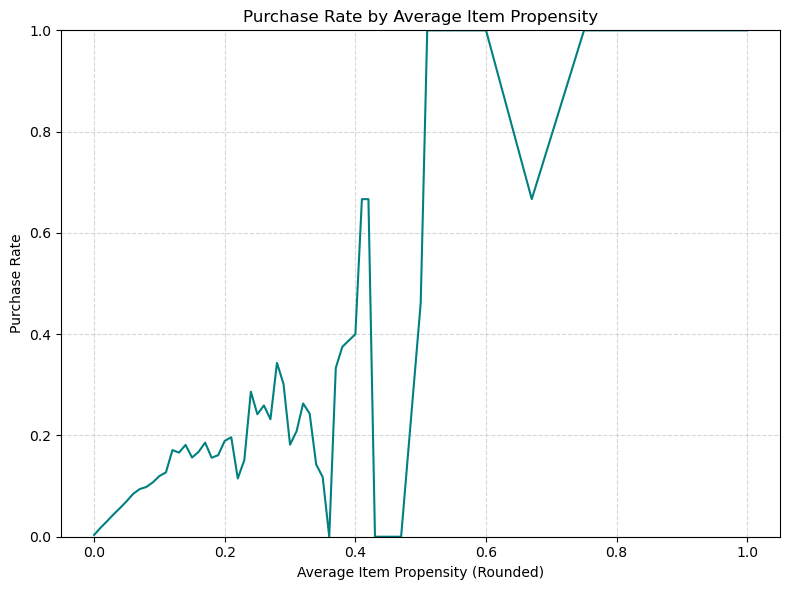

In [5]:
# Aggregate average item propensity scores against
# purchase rate to visualise the relationship
train_session_df['avg_item_propensity_rnd'] = train_session_df['avg_item_propensity'].round(2)

session_propensity_agg = train_session_df.groupby('avg_item_propensity_rnd').agg(
    purchase_rate=('session_purchase', 'mean')
).reset_index()

plt.figure(figsize=FIG_SIZE)
sns.lineplot(data=session_propensity_agg, x='avg_item_propensity_rnd', y='purchase_rate', color='teal')
plt.title('Purchase Rate by Average Item Propensity')
plt.xlabel('Average Item Propensity (Rounded)')
plt.ylabel('Purchase Rate')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

As we expect, sessions with a higher average propensity score are more likely to result in a purchase. We also observe that the feature is not very stable as there is some variance in the purchase rate as the average propensity score increases. This is expected, as the propensity score is not a perfect predictor of purchase behaviour, and there are other factors that influence whether a session will result in a purchase or not.

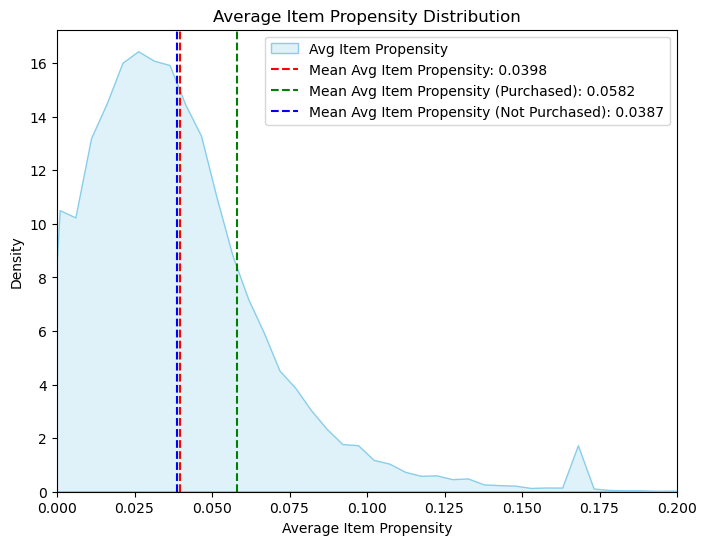

In [6]:
# Visualise the distribution of session propensity scores
# Compute mean values
avg_item_propensity_mean = train_session_df['avg_item_propensity'].mean()
avg_item_propensity_mean_purchased = train_session_df[train_session_df['session_purchase'] == 1]['avg_item_propensity'].mean()
avg_item_propensity_mean_not_purchased = train_session_df[train_session_df['session_purchase'] == 0]['avg_item_propensity'].mean()

# Plot
plt.figure(figsize=FIG_SIZE)
sns.kdeplot(train_session_df['avg_item_propensity'], fill=True, color='skyblue', label='Avg Item Propensity') # type: ignore

# Mean lines
plt.axvline(avg_item_propensity_mean, color='red', linestyle='--', label=f'Mean Avg Item Propensity: {avg_item_propensity_mean:.4f}')
plt.axvline(avg_item_propensity_mean_purchased, color='green', linestyle='--', label=f'Mean Avg Item Propensity (Purchased): {avg_item_propensity_mean_purchased:.4f}')
plt.axvline(avg_item_propensity_mean_not_purchased, color='blue', linestyle='--', label=f'Mean Avg Item Propensity (Not Purchased): {avg_item_propensity_mean_not_purchased:.4f}')

# Labels and formatting
plt.title('Average Item Propensity Distribution')
plt.xlabel('Average Item Propensity')
plt.ylabel('Density')
plt.xlim(0, 0.2)
plt.legend()
plt.show()

The average item propensity score is also skewed, with a majority of items having a low propensity score. As such, we expect that this feature will be informative for the proportion of the data that has a high average propensity score, but not for the majority of the data that has a low average propensity score.

### 2.3 Temporal Features

We then observe the temporal features of the data, specifically the time of day and day of week features to see how they relate to the target variable.

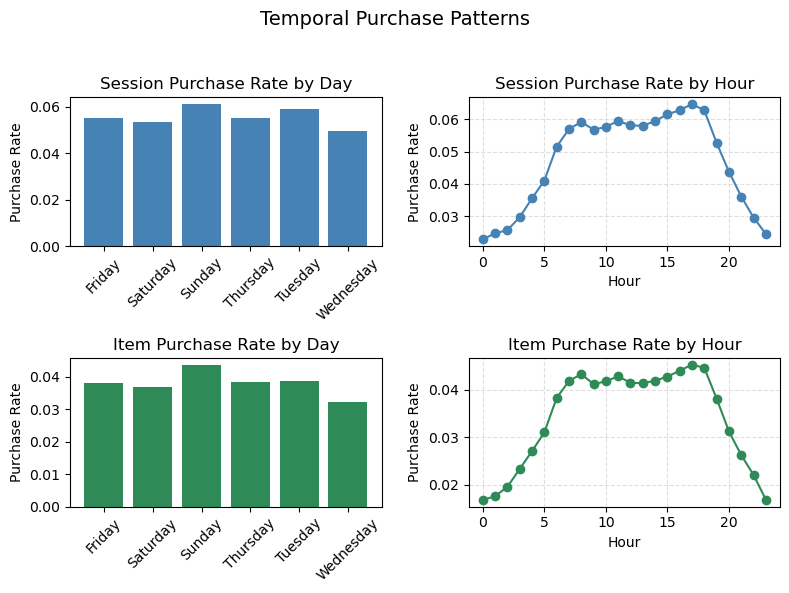

<Figure size 640x480 with 0 Axes>

In [7]:
day_dict = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Temporal feature for session classifier
train_session_df['time'] = pd.to_datetime(train_session_df['time'], utc=True, format='mixed')
train_session_df['day'] = train_session_df['time'].dt.day
train_session_df['hour'] = train_session_df['time'].dt.hour

# Temporal feature for item classifier
train_item_df['time'] = pd.to_datetime(train_item_df['time'], utc=True, format='mixed')
train_item_df['day'] = train_item_df['time'].dt.day
train_item_df['hour'] = train_item_df['time'].dt.hour

# Convert day of week to categorical
train_session_df['day'] = train_session_df['day'].map(day_dict)
train_item_df['day'] = train_item_df['day'].map(day_dict)

# Aggregate statistics
agg_day_session = train_session_df.groupby('day').agg(
    purchase_rate=('session_purchase', 'mean')
).reset_index()

agg_hour_session = train_session_df.groupby('hour').agg(
    purchase_rate=('session_purchase', 'mean')
).reset_index()

agg_day_item = train_item_df.groupby('day').agg(
    purchase_rate=('item_purchase', 'mean')
).reset_index()

agg_hour_item = train_item_df.groupby('hour').agg(
    purchase_rate=('item_purchase', 'mean')
).reset_index()

# Visualise aggregated statistics
fig, axs = plt.subplots(2, 2, figsize=FIG_SIZE)
fig.suptitle("Temporal Purchase Patterns", fontsize=14)

# Row 1, Col 1: Session Purchase Rate by Day
axs[0, 0].bar(agg_day_session['day'], agg_day_session['purchase_rate'], color='steelblue')
axs[0, 0].set_title("Session Purchase Rate by Day")
axs[0, 0].set_ylabel("Purchase Rate")
axs[0, 0].tick_params(axis='x', rotation=45)

# Row 1, Col 2: Session Purchase Rate by Hour
axs[0, 1].plot(agg_hour_session['hour'], agg_hour_session['purchase_rate'], marker='o', color='steelblue')
axs[0, 1].set_title("Session Purchase Rate by Hour")
axs[0, 1].set_xlabel("Hour")
axs[0, 1].set_ylabel("Purchase Rate")
axs[0, 1].grid(True, linestyle='--', alpha=0.4)

# Row 2, Col 1: Item Purchase Rate by Day
axs[1, 0].bar(agg_day_item['day'], agg_day_item['purchase_rate'], color='seagreen')
axs[1, 0].set_title("Item Purchase Rate by Day")
axs[1, 0].set_ylabel("Purchase Rate")
axs[1, 0].tick_params(axis='x', rotation=45)

# Row 2, Col 2: Item Purchase Rate by Hour
axs[1, 1].plot(agg_hour_item['hour'], agg_hour_item['purchase_rate'], marker='o', color='seagreen')
axs[1, 1].set_title("Item Purchase Rate by Hour")
axs[1, 1].set_xlabel("Hour")
axs[1, 1].set_ylabel("Purchase Rate")
axs[1, 1].grid(True, linestyle='--', alpha=0.4)

# Layout adjustment
plt.tight_layout(rect=[0, 0, 1, 0.95]) # type: ignore
plt.show()
plt.savefig('./figures/temporal_purchase_patterns.png')

We observe that for both classifiers, the time of day is very informative, with hours during the day having a significant impact on the likelihood of a purchase. This is expected, as users are more likely to make purchases during certain times of the day, such as during lunch breaks or after work hours.

We note that whilst there is some variance in the purchase rate across different days of the week, it is not as significant as the variance across different hours of the day. This is expected, as users are more likely to make purchases during certain times of the day, rather than on certain days of the week.

### 2.4 Aggregate Statistics

Here we look at aggregate statistics for the session and item classifiers. These features are useful for understanding the overall trends in the data, and can be used to inform how effective the engineered features are.

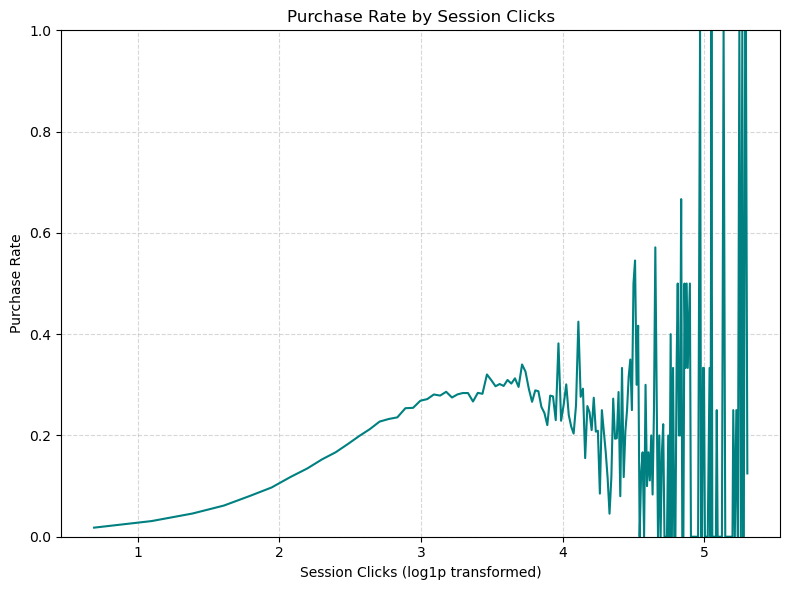

In [9]:
# Aggregate session data on clicks 
# to observe trend in purchase rate
agg_session_clicks = train_session_df.groupby('session_clicks').agg(
    purchase_rate=('session_purchase', 'mean')
).reset_index()

plt.figure(figsize=FIG_SIZE)
sns.lineplot(data=agg_session_clicks, x='session_clicks', y='purchase_rate', color='teal')
plt.title('Purchase Rate by Session Clicks')
plt.xlabel('Session Clicks (log1p transformed)')
plt.ylabel('Purchase Rate')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

We observe an increasing trend in the purchase rate as the number of clicks in the session increases. This is expected, as users are more likely to make a purchase if they have clicked on more items in the session. However, we note that as the number of clicks increases, the purchase rate becomes more unstable, with significant variance in the purchase rate for sessions with a high number of clicks. This is expected, as users may click on many items in a session without making a purchase, and the purchase rate will be lower for these sessions.

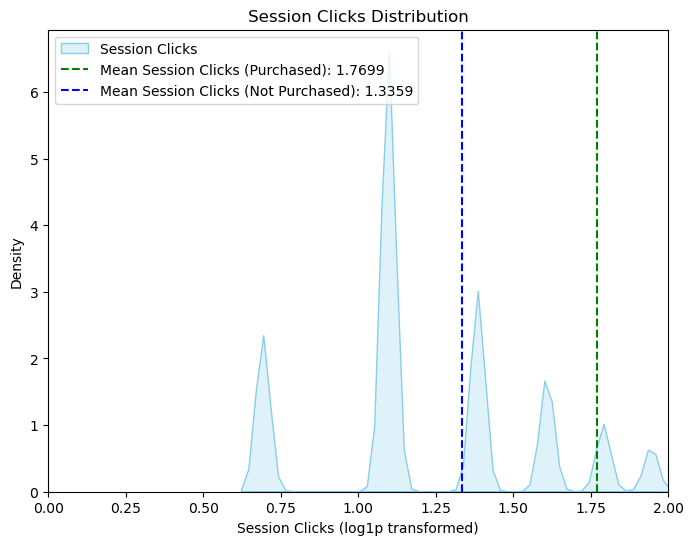

In [5]:
# Visualise distribution of session clicks
session_clicks_mean_purchased = train_session_df[train_session_df['session_purchase'] == 1]['session_clicks'].mean()
session_clicks_mean_not_purchased = train_session_df[train_session_df['session_purchase'] == 0]['session_clicks'].mean()

plt.figure(figsize=FIG_SIZE)
sns.kdeplot(data=train_session_df, x='session_clicks', fill=True, color='skyblue', label='Session Clicks')
plt.axvline(session_clicks_mean_purchased, color='green', linestyle='--', label=f'Mean Session Clicks (Purchased): {session_clicks_mean_purchased:.4f}')
plt.axvline(session_clicks_mean_not_purchased, color='blue', linestyle='--', label=f'Mean Session Clicks (Not Purchased): {session_clicks_mean_not_purchased:.4f}')

plt.title('Session Clicks Distribution')
plt.xlabel('Session Clicks (log1p transformed)')
plt.ylabel('Density')
plt.xlim(0, 2)
plt.legend()
plt.show()

The distribution of session clicks appears to be multimodal. This is to be expected, as multiple users will have common behaviours, such as clicking in a session a given number of times. This is a common scenario in clickstream data, and we expect to see similar patterns in the data. Notably the density of each mode gradually decreases as the number of clicks increases, indicating that the majority of users will click on a small number of items in a session, and only a small number of users will click on a large number of items in a session.

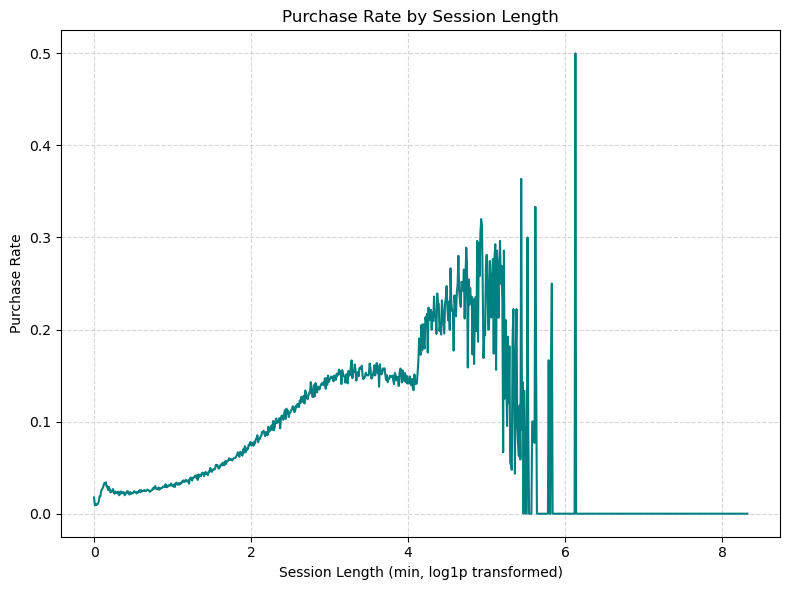

In [15]:
# Aggregate session data on length
# to observe trend in purchase rate
train_session_df['session_length_rnd'] = train_session_df['session_length'].apply(lambda x: round(x, 2))

agg_session_length = train_session_df.groupby('session_length_rnd').agg(
    purchase_rate=('session_purchase', 'mean')
).reset_index()

plt.figure(figsize=FIG_SIZE)
sns.lineplot(data=agg_session_length, x='session_length_rnd', y='purchase_rate', color='teal')
plt.title('Purchase Rate by Session Length')
plt.xlabel('Session Length (min, log1p transformed)')
plt.ylabel('Purchase Rate')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

We observe that purchase rate also increases accordingly with session length. However, we note that this is very unstable with a significant amount of variance in purchase rate for all session lengths. In the visualisation, we see a general increase in purchase rate as session length increases, but towards the higher end of session lengths, the purchase rate becomes more unstable and ultimately decreases and reaches what appears to be zero. This may be due to the fact that users are more likely to make a purchase if they have spent more time in the session, but also that users may spend a long time in a session without making a purchase, leading to a lower purchase rate for these sessions. This may cause some issues with the model, as it may not be able to generalise well to sessions with a long length.

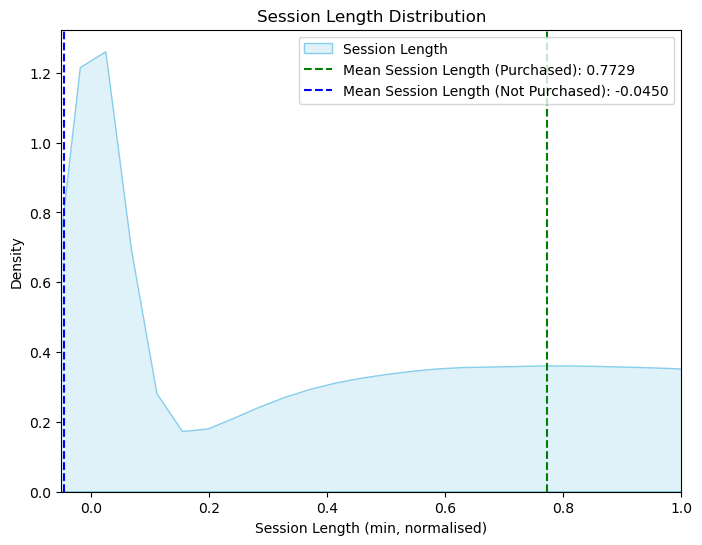

In [18]:
# Visualise distribution of session length
session_length_mean_purchased = train_session_df[train_session_df['session_purchase'] == 1]['session_length_z'].mean()
session_length_mean_not_purchased = train_session_df[train_session_df['session_purchase'] == 0]['session_length_z'].mean()

plt.figure(figsize=FIG_SIZE)
sns.kdeplot(data=train_session_df, x='session_length', fill=True, color='skyblue', label='Session Length') # type: ignore
plt.axvline(session_length_mean_purchased, color='green', linestyle='--', label=f'Mean Session Length (Purchased): {session_length_mean_purchased:.4f}')
plt.axvline(session_length_mean_not_purchased, color='blue', linestyle='--', label=f'Mean Session Length (Not Purchased): {session_length_mean_not_purchased:.4f}')
plt.title('Session Length Distribution')
plt.xlabel('Session Length (min, normalised)')
plt.ylabel('Density')
plt.xlim(-0.05, 1)
plt.legend()
plt.show()

Majority of the data has a lower session length, but a considerable density of sessions have a normalised session length which is quite high. We also note that the mean session length for sessions with a purchase is significantly higher than that for sessions without a purchase, indicating that the session length is informative and can be used to improve the performance of the models.

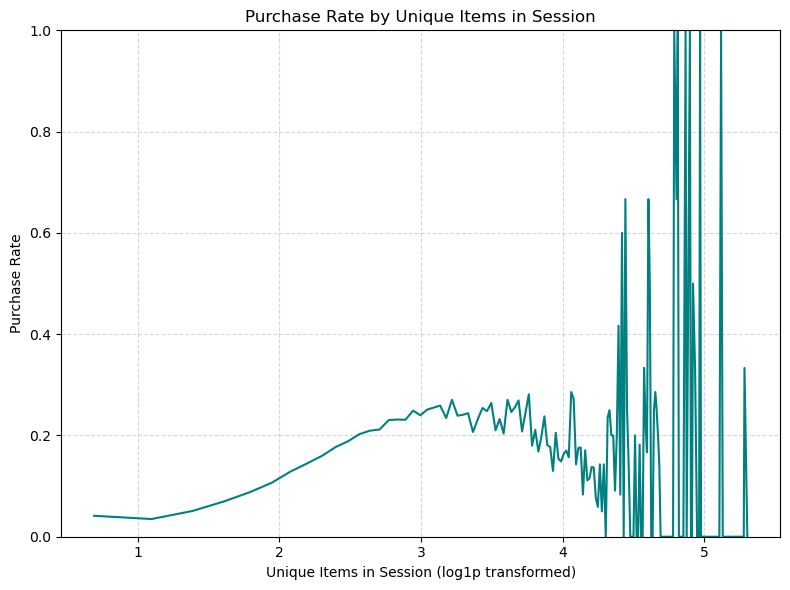

In [19]:
# Aggregate session data on unique items
agg_session_items = train_session_df.groupby('unique_items').agg(
    purchase_rate=('session_purchase', 'mean')
).reset_index()

plt.figure(figsize=FIG_SIZE)
sns.lineplot(data=agg_session_items, x='unique_items', y='purchase_rate', color='teal')
plt.title('Purchase Rate by Unique Items in Session')
plt.xlabel('Unique Items in Session (log1p transformed)')
plt.ylabel('Purchase Rate')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

As expected, teh purchase rate increases as the number of unique items in the session increases. This is expected, as users are more likely to make a purchase if they have clicked on more unique items in the session. However, we note that as the number of unique items increases, the purchase rate becomes more unstable, with significant variance in the purchase rate for sessions with a high number of unique items.

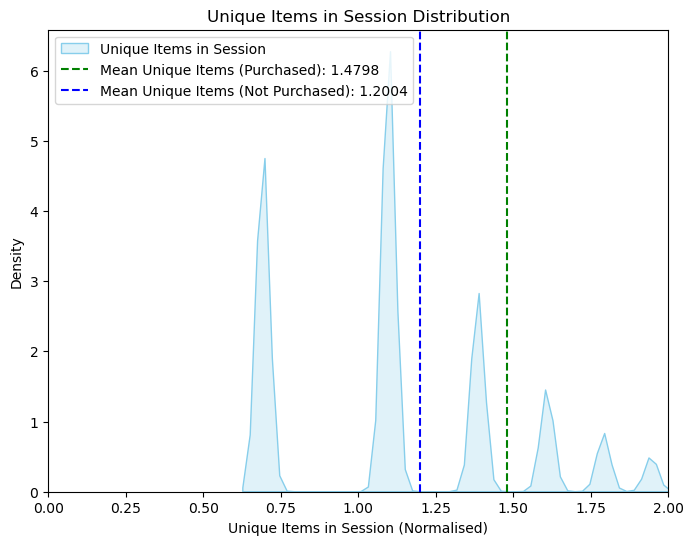

In [21]:
# Visualise distribution of unique items
unique_items_mean_purchased = train_session_df[train_session_df['session_purchase'] == 1]['unique_items'].mean()
unique_items_mean_not_purchased = train_session_df[train_session_df['session_purchase'] == 0]['unique_items'].mean()

plt.figure(figsize=FIG_SIZE)
sns.kdeplot(data=train_session_df, x='unique_items', fill=True, color='skyblue', label='Unique Items in Session') # type: ignore
plt.axvline(unique_items_mean_purchased, color='green', linestyle='--', label=f'Mean Unique Items (Purchased): {unique_items_mean_purchased:.4f}')
plt.axvline(unique_items_mean_not_purchased, color='blue', linestyle='--', label=f'Mean Unique Items (Not Purchased): {unique_items_mean_not_purchased:.4f}')
plt.title('Unique Items in Session Distribution')
plt.xlabel('Unique Items in Session (log1p transformed)')
plt.ylabel('Density')
plt.xlim(0, 2)
plt.legend()
plt.show()

Interestingly, we observe that the distribution of unique items in a session is also multimodal, indicating that there are common behaviours in the number of items observed by users in a session. This is expected, as users are more likely to click on a small number of items in a session, and only a small number of users will click on a large number of items in a session.

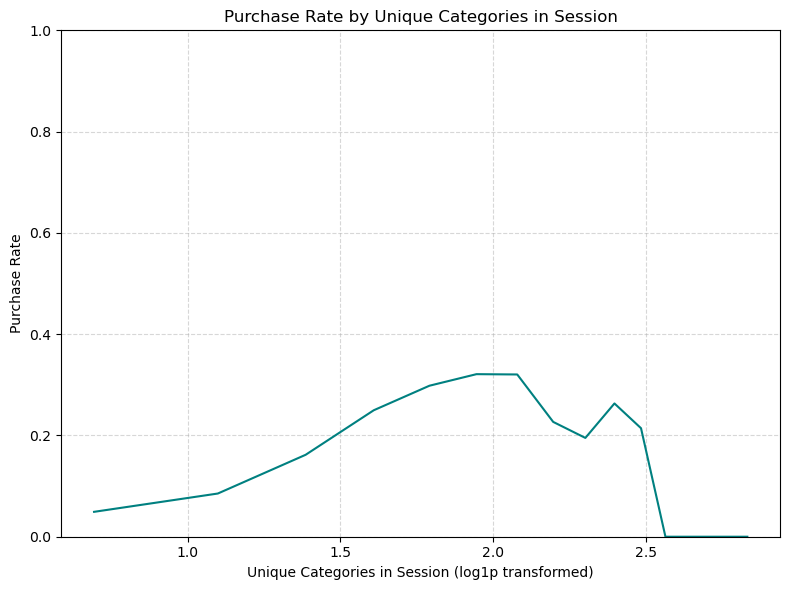

In [22]:
# Aggregate session data on unique categories
agg_session_categories = train_session_df.groupby('unique_categories').agg(
    purchase_rate=('session_purchase', 'mean')
).reset_index()

plt.figure(figsize=FIG_SIZE)
sns.lineplot(data=agg_session_categories, x='unique_categories', y='purchase_rate', color='teal')
plt.title('Purchase Rate by Unique Categories in Session')
plt.xlabel('Unique Categories in Session (log1p transformed)')
plt.ylabel('Purchase Rate')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

As the number of unique categories in a session increases, the purchase rate also increases. However, we note that past a certain point, the purchase starts to decrease reaching zero for sessions with a very high number of unique categories. This may mean that users with a high number of unique categories in a session are less likely to make a purchase, as they may be browsing without a specific intent to buy.

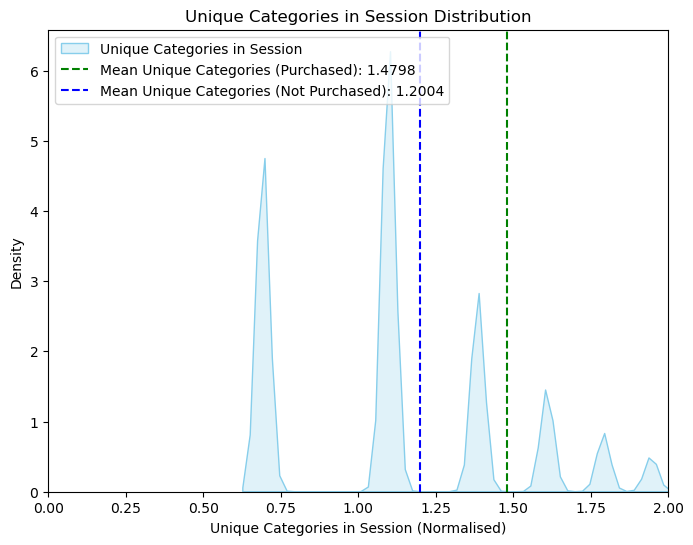

In [24]:
# Visualise distribution of unique items
unique_items_mean_purchased = train_session_df[train_session_df['session_purchase'] == 1]['unique_items'].mean()
unique_items_mean_not_purchased = train_session_df[train_session_df['session_purchase'] == 0]['unique_items'].mean()

plt.figure(figsize=FIG_SIZE)
sns.kdeplot(data=train_session_df, x='unique_items', fill=True, color='skyblue', label='Unique Categories in Session') # type: ignore
plt.axvline(unique_items_mean_purchased, color='green', linestyle='--', label=f'Mean Unique Categories (Purchased): {unique_items_mean_purchased:.4f}')
plt.axvline(unique_items_mean_not_purchased, color='blue', linestyle='--', label=f'Mean Unique Categories (Not Purchased): {unique_items_mean_not_purchased:.4f}')
plt.title('Unique Categories in Session Distribution')
plt.xlabel('Unique Categories in Session (log1p transformed)')
plt.ylabel('Density')
plt.xlim(0, 2)
plt.legend()
plt.show()

Similarly to other features, we observe that the distribution of unique categories in a session is also multimodal, indicating that there are common behaviours in the number of categories observed by users in a session.

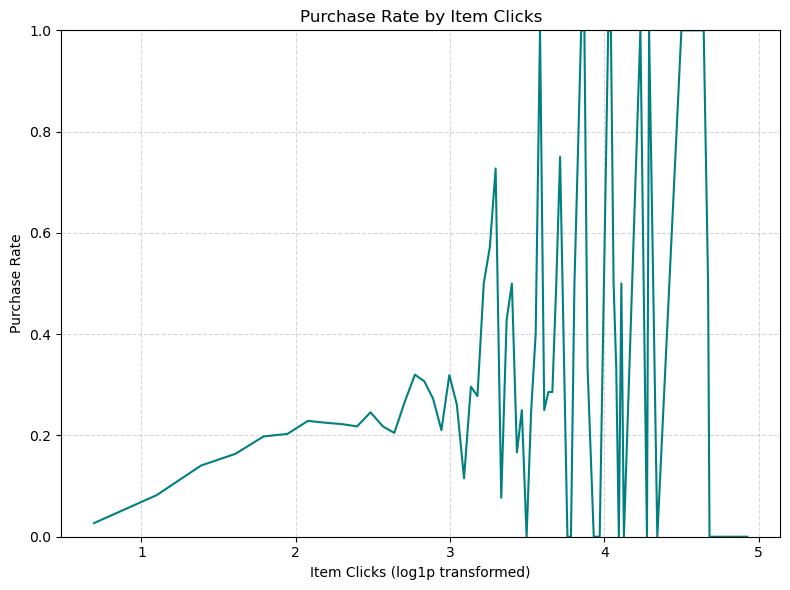

In [25]:
# Aggregate item data on clicks
# to observe trend in purchase rate
agg_item_clicks = train_item_df.groupby('item_clicks').agg(
    purchase_rate=('item_purchase', 'mean')
).reset_index()

plt.figure(figsize=FIG_SIZE)
sns.lineplot(data=agg_item_clicks, x='item_clicks', y='purchase_rate', color='teal')
plt.title('Purchase Rate by Item Clicks')
plt.xlabel('Item Clicks (log1p transformed)')
plt.ylabel('Purchase Rate')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

We observe a general increase in purchase rate as the number of clicks on an item increases. This becomes more unstable as the number of clicks increases, however, we continue to see a general increase in trend for the purchase rate.

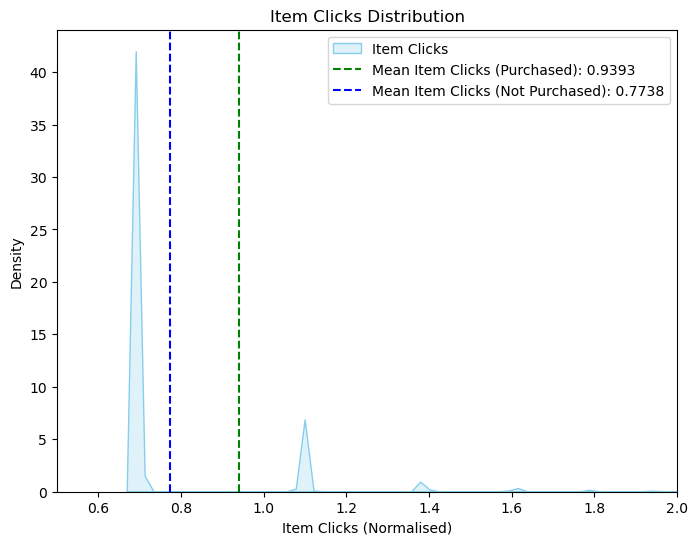

In [28]:
# Visualise the distribution of item clicks
item_clicks_mean_purchased = train_item_df[train_item_df['item_purchase'] == 1]['item_clicks'].mean()
item_clicks_mean_not_purchased = train_item_df[train_item_df['item_purchase'] == 0]['item_clicks'].mean()
plt.figure(figsize=FIG_SIZE)
sns.kdeplot(data=train_item_df, x='item_clicks', fill=True, color='skyblue', label='Item Clicks') # type: ignore
plt.axvline(item_clicks_mean_purchased, color='green', linestyle='--', label=f'Mean Item Clicks (Purchased): {item_clicks_mean_purchased:.4f}')
plt.axvline(item_clicks_mean_not_purchased, color='blue', linestyle='--', label=f'Mean Item Clicks (Not Purchased): {item_clicks_mean_not_purchased:.4f}')
plt.title('Item Clicks Distribution')
plt.xlabel('Item Clicks (log1p transformed)')
plt.ylabel('Density')
plt.xlim(0.5, 2)
plt.legend()
plt.show()

Just like features from the session classifier, we observe that the distribution of clicks on an item is also multimodal, indicating that there are common behaviours in the number of clicks on an item. This is expected, as users are likely to click on an item a small number of times in a session, and only a small number of users will click on an item a large number of times in a session.

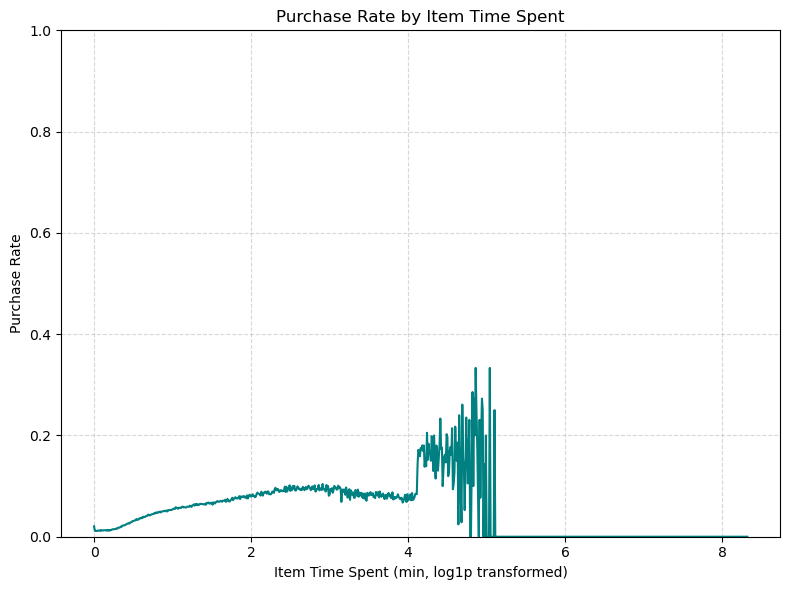

In [29]:
# Aggregate item data on length
# to observe trend in purchase rate
train_item_df['item_time_rnd'] = train_item_df['item_time'].round(2)

agg_item_time = train_item_df.groupby('item_time_rnd').agg(
    purchase_rate=('item_purchase', 'mean')
).reset_index()

plt.figure(figsize=FIG_SIZE)
sns.lineplot(data=agg_item_time, x='item_time_rnd', y='purchase_rate', color='teal')
plt.title('Purchase Rate by Item Time Spent')
plt.xlabel('Item Time Spent (min, log1p transformed)')
plt.ylabel('Purchase Rate')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

We observe that the time on an item is very unstable and shows significant variance in purchase rate for all time on item values. Despite this, we are still able to observe an increasing trend in purchase rate as the time on item increases.

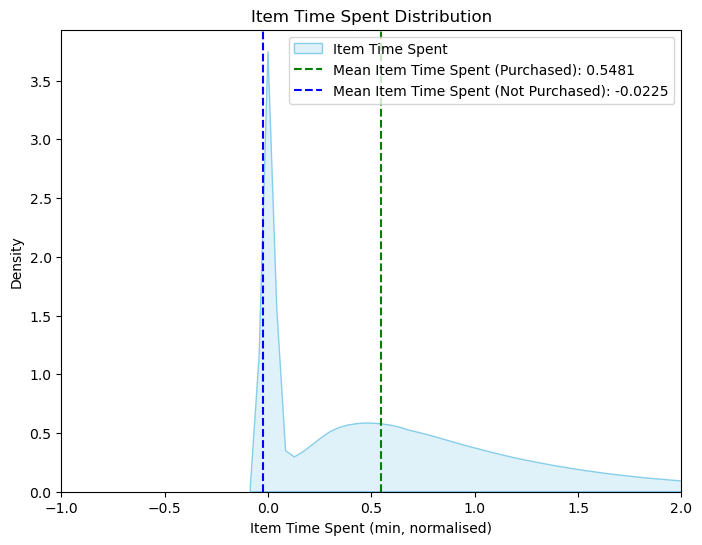

In [31]:
# Visualise the distribution of item time spent
item_time_mean_purchased = train_item_df[train_item_df['item_purchase'] == 1]['item_time_z'].mean()
item_time_mean_not_purchased = train_item_df[train_item_df['item_purchase'] == 0]['item_time_z'].mean()

plt.figure(figsize=FIG_SIZE)
sns.kdeplot(data=train_item_df, x='item_time', fill=True, color='skyblue', label='Item Time Spent') # type: ignore
plt.axvline(item_time_mean_purchased, color='green', linestyle='--', label=f'Mean Item Time Spent (Purchased): {item_time_mean_purchased:.4f}')
plt.axvline(item_time_mean_not_purchased, color='blue', linestyle='--', label=f'Mean Item Time Spent (Not Purchased): {item_time_mean_not_purchased:.4f}')
plt.title('Item Time Spent Distribution')
plt.xlabel('Item Time Spent (min, normalised)')
plt.ylabel('Density')
plt.xlim(-1, 2)
plt.legend()
plt.show()

The distribution of time on item indicates that a vast majority of items have a low time on item, with a considerable density of items having a higher time on an item. We also note that the mean time on item for items with a purchase is significantly higher than that for items without a purchase, indicating that the time on item is informative and can be used to improve the performance of the models.

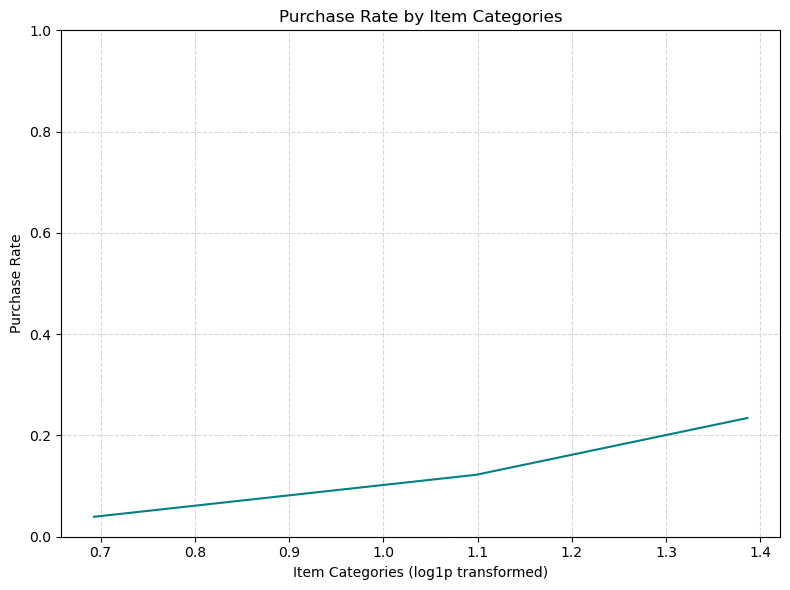

In [32]:
# Aggregate item data on categories
agg_item_categories = train_item_df.groupby('item_categories').agg(
    purchase_rate=('item_purchase', 'mean')
).reset_index()

plt.figure(figsize=FIG_SIZE)
sns.lineplot(data=agg_item_categories, x='item_categories', y='purchase_rate', color='teal')
plt.title('Purchase Rate by Item Categories')
plt.xlabel('Item Categories (log1p transformed)')
plt.ylabel('Purchase Rate')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

The purchase rate for the number of categories clicked on an item is very stable and shows a clear increasing trend as the number of categories clicked on an item increases. This is expected, as users are more likely to make a purchase if they have clicked on more categories on an item.

## 3. Feature Documentation

### 3.1 Session Classification Features

| Feature Name | Type | Description |
|--------------|------|-------------| 
| session_id | str | Unique identifier for the session |
| time | str | Time the session started in ISO format |
| session_length | float | Length of the session in seconds |
| session_length_z | float | Normalised length of the session (z-score) |
| session_clicks | float | Number of clicks in the session |
| session_clicks_z | float | Normalised number of clicks in the session (z-score) |
| day_of_week | int | Day of the week when the session occurred weekend (1) or weekday (0) |
| hour_sin | float | Sine component of the time of day |
| hour_cos | float | Cosine component of the time of day |
| max_item_propensity | float | Maximum propensity score of items clicked in the session |
| avg_item_propensity | float | Average propensity score of items clicked in the session |
| unique_items | int | Number of unique items clicked in the session |
| unique_items_z | float | Normalised number of unique items clicked in the session (z-score) |
| unique_categories | int | Number of unique categories clicked in the session |
| unique_categories_z | float | Normalised number of unique categories clicked in the session (z-score) |
| session_purchase | int | Whether an item was purchased in the session (1) or not (0) |

The exact features used for for the model will be:

  - `session_length_z`
  - `session_clicks_z`
  - `day_of_week`
  - `hour_sin`
  - `hour_cos`
  - `max_item_propensity`
  - `avg_item_propensity`
  - `unique_items_z`
  - `unique_categories_z`

The target variable for this classifier will be the `session_purchase` column, which indicates whether an item was purchased in the session (1) or not (0).

### 3.2 Item Classification Features

| Feature Name | Type | Description |
|--------------|------|-------------|
| session_id | str | Unique identifier for the session |
| item_id | str | Unique identifier for the item |
| time | str | First contact time for the item in ISO format |
| item_clicks | float | Number of clicks on the item in the session |
| item_clicks_z | float | Normalised number of clicks on the item in the session (z-score) |
| item_time | float | Total time spent on the item across all clicks in the session |
| item_time_z | float | Normalised total time spent on the item across all clicks in the session (z-score) |
| day_of_week | int | Day of the week when the session occurred weekend (1) or weekday (0) |
| hour_sin | float | Sine component of the time of day |
| hour_cos | float | Cosine component of the time of day |
| item_propensity | float | Propensity score of the item |
| item_categories | int | Number of unique categories in session for item |
| item_categories z | float | Normalised number of unique categories in session for item (z-score) |
| session_purchase | int | Whether an item was purchased in the session (1) or not (0) |
| item_purchase | int | Whether the item was purchased in the session (1) or not (0) |

The exact features used for for the model will be:

  - `item_clicks_z`
  - `item_time_z`
  - `day_of_week`
  - `hour_sin`
  - `hour_cos`
  - `item_propensity`
  - `item_categories_z`

The target variable for this classifier will be the `item_purchase` column, which indicates whether the item was purchased in the session (1) or not (0). Note that the `session_purchase` column will be used to filter the data for training this classifier, ensuring that we only train on sessions where an item was purchased.